In [13]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import os
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical

### Data Loading

In [14]:
# Load the data into a pandas DataFrame
print(os.getcwd())
df = pd.read_csv(
    filepath_or_buffer=os.getcwd()+'/../../data/monks/monks-1.train',
    names=['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'],
    delimiter=' '
)

# Display the loaded data
df

/Users/gianlucapanzani/Documents/GitHub/Machine_Learning_Project/frameworks/tfkeras


,target,col1,col2,col3,col4,col5,col6,id
NaN,1,1,1,1,1,3,1,data_5
NaN,1,1,1,1,1,3,2,data_6
NaN,1,1,1,1,3,2,1,data_19
NaN,1,1,1,1,3,3,2,data_22
NaN,1,1,1,2,1,2,1,data_27
...,...,...,...,...,...,...,...,...
NaN,1,3,3,2,1,4,2,data_416
NaN,1,3,3,2,3,1,2,data_426
NaN,1,3,3,2,3,2,2,data_428
NaN,1,3,3,2,3,3,2,data_430


### 1-Hot Encoding

In [15]:
# Initializing labels/targets vector
y = df['target'].values.astype(float)

# Drop of the IDs and the targets
df = df.drop(columns=['target','id'], axis=1)

# Initializing the one-hot DataFrame
df_copy = df.copy(deep=True)

# Iteration on the columns of the DataFrame
for column in df.columns:

    # Creation of the one-hot encoding's columns
    df_one_hot = pd.get_dummies(df[column], dtype=float)

    # Change the name of the columns
    df_one_hot = df_one_hot.set_axis([column+'_'+str(col) for col in df_one_hot.columns], axis=1)

    # Drop of the initial column
    df_copy.drop(labels=column, axis=1, inplace=True)

    # Concatenation of the new columns to the DataFrame
    df_copy = pd.concat([df_copy,df_one_hot], axis=1)

# Print of the obtained DataFrame
df_copy

,col1_1,col1_2,col1_3,col2_1,col2_2,col2_3,col3_1,col3_2,col4_1,col4_2,col4_3,col5_1,col5_2,col5_3,col5_4,col6_1,col6_2
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
NaN,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
NaN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


### Grid Search parameters

In [16]:
# Parameters' space for Grid Search
param_space = {
    'units': [3, 4],
    'optimizer': ['sgd'],
    'learning_rate': [0.1, 0.2, 0.3],
    'batch_size': [16, 32, 64],
    'epochs': [375],
    'weight_decay': [0.01, 0.02, 0.03],
    'momentum': [0.7, 0.8, 0.9],
    'loss': ['binary_crossentropy'],
    'activation': ['relu'],
    'output_activation': ['sigmoid'],
    'metrics': ['accuracy']
}

# Parameters' space for Grid Search (accuracy=0.89)
#param_space = {
    #'units': [3, 4],
    #'optimizer': ['sgd'],
    #'learning_rate': [0.01, 0.05, 0.1, 0.2],
    #'batch_size': [15, 16, 17],
    #'epochs': [1250, 1500, 1750],
    #'weight_decay': [0.005, 0.01],
    #'momentum': [0.7, 0.8, 0.9],
    #'loss': ['binary_crossentropy'] #['log_loss', 'binary_crossentropy']
#}

### Model Selection

Trial  0: Units=3, Learning Rate=0.1, Weight Decay=0.03, Epochs=375, Batch Size=32, Momentum=0.9 Accuracy=0.7097


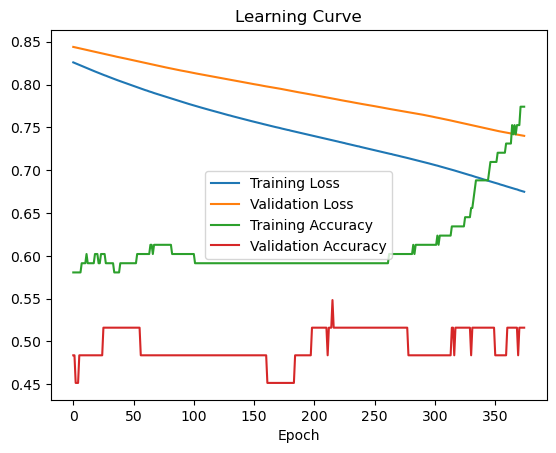

Trial  1: Units=3, Learning Rate=0.3, Weight Decay=0.03, Epochs=375, Batch Size=64, Momentum=0.8 Accuracy=0.5000


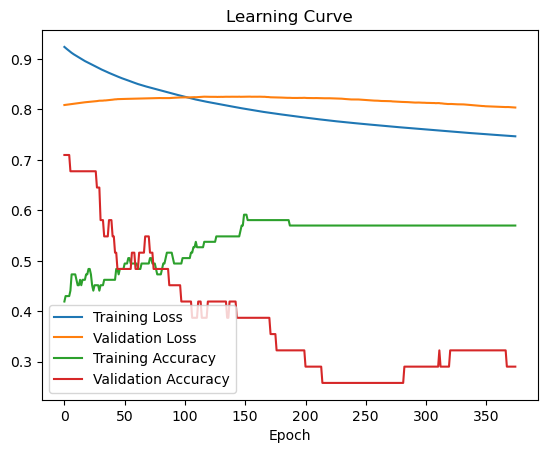

Trial  2: Units=3, Learning Rate=0.1, Weight Decay=0.02, Epochs=375, Batch Size=32, Momentum=0.8 Accuracy=0.7419


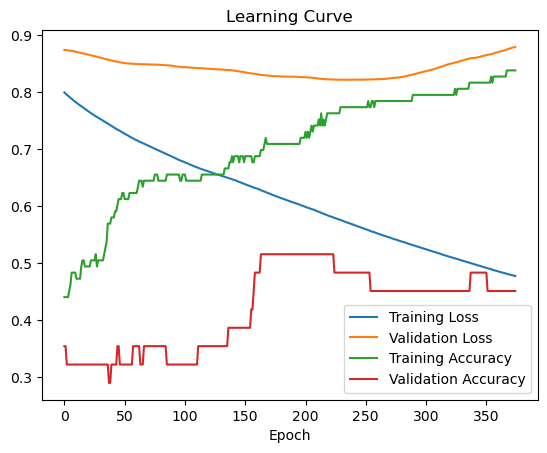

Trial  3: Units=3, Learning Rate=0.3, Weight Decay=0.02, Epochs=375, Batch Size=16, Momentum=0.9 Accuracy=0.7823


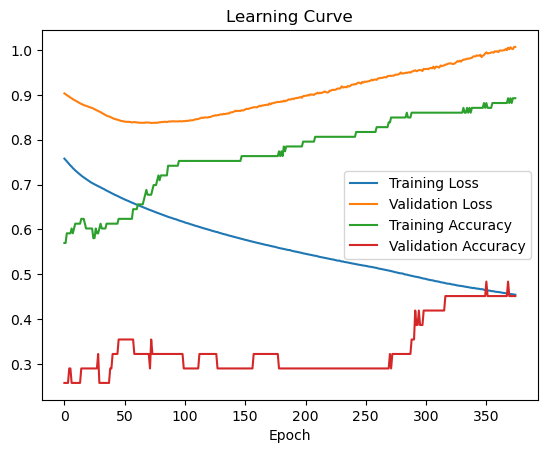

Trial  4: Units=4, Learning Rate=0.1, Weight Decay=0.02, Epochs=375, Batch Size=16, Momentum=0.7 Accuracy=0.8468


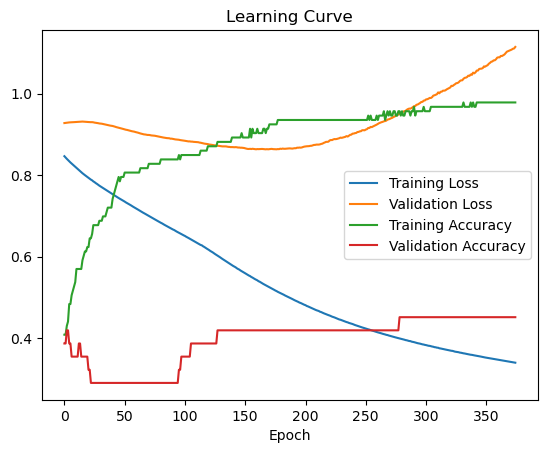

Trial  5: Units=4, Learning Rate=0.3, Weight Decay=0.03, Epochs=375, Batch Size=32, Momentum=0.9 Accuracy=0.8306


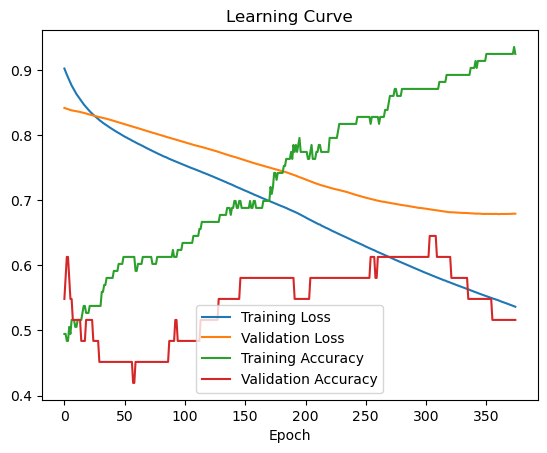

Trial  6: Units=4, Learning Rate=0.1, Weight Decay=0.03, Epochs=375, Batch Size=16, Momentum=0.7 Accuracy=0.8065


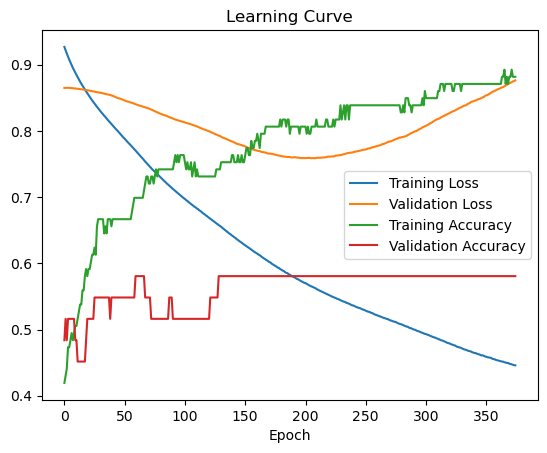

Trial  7: Units=3, Learning Rate=0.2, Weight Decay=0.03, Epochs=375, Batch Size=32, Momentum=0.8 Accuracy=0.7419


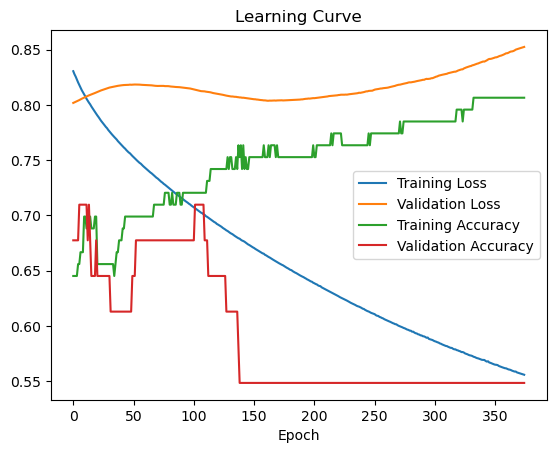

Trial  8: Units=3, Learning Rate=0.1, Weight Decay=0.03, Epochs=375, Batch Size=32, Momentum=0.9 Accuracy=0.7097


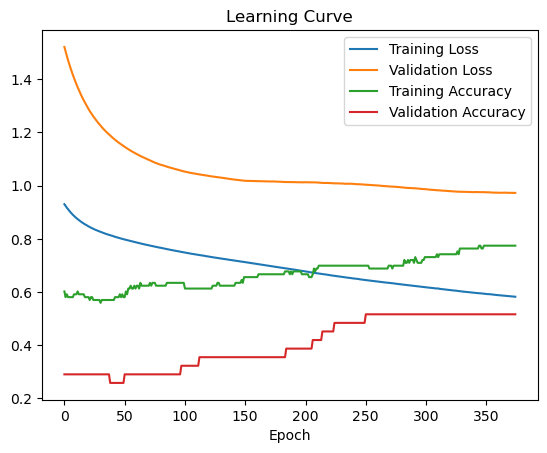

Trial  9: Units=3, Learning Rate=0.2, Weight Decay=0.01, Epochs=375, Batch Size=16, Momentum=0.7 Accuracy=0.7742


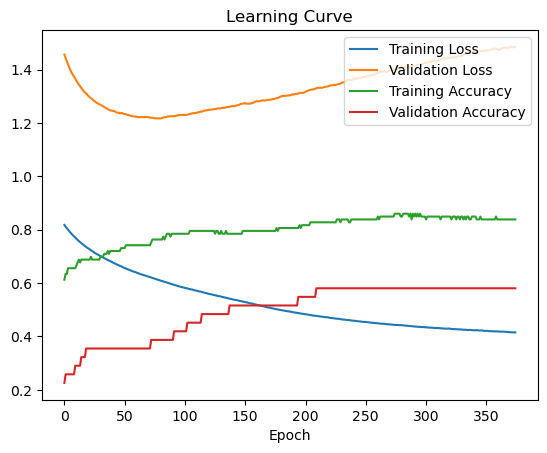

Trial 10: Units=3, Learning Rate=0.3, Weight Decay=0.02, Epochs=375, Batch Size=32, Momentum=0.9 Accuracy=0.7258


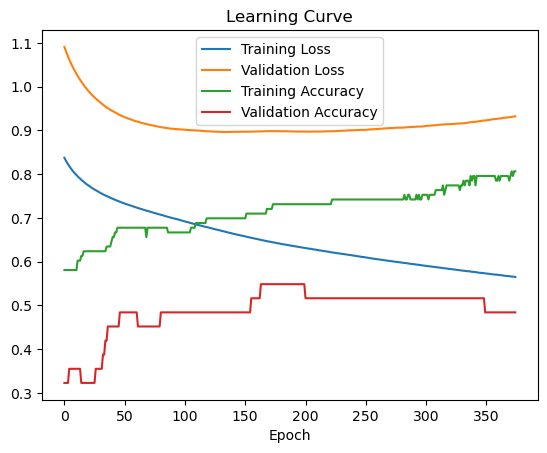

Trial 11: Units=4, Learning Rate=0.3, Weight Decay=0.02, Epochs=375, Batch Size=32, Momentum=0.7 Accuracy=0.7258


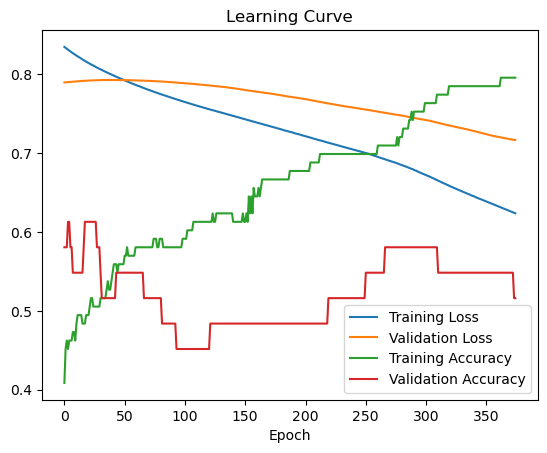

Trial 12: Units=3, Learning Rate=0.2, Weight Decay=0.03, Epochs=375, Batch Size=64, Momentum=0.9 Accuracy=0.7823


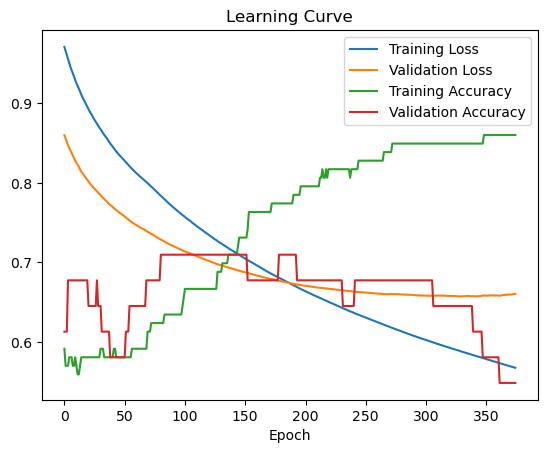

Trial 13: Units=3, Learning Rate=0.1, Weight Decay=0.01, Epochs=375, Batch Size=32, Momentum=0.9 Accuracy=0.6935


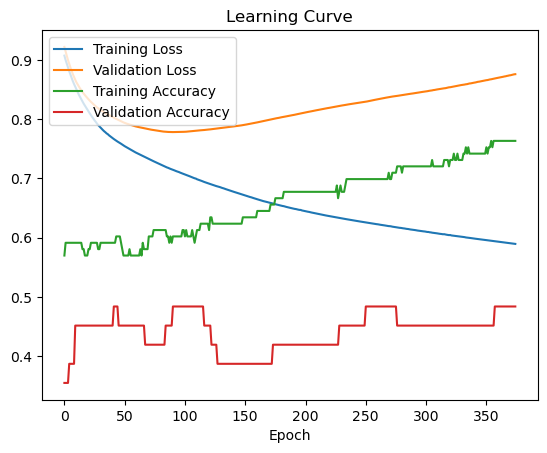

Trial 14: Units=3, Learning Rate=0.2, Weight Decay=0.03, Epochs=375, Batch Size=32, Momentum=0.7 Accuracy=0.5968


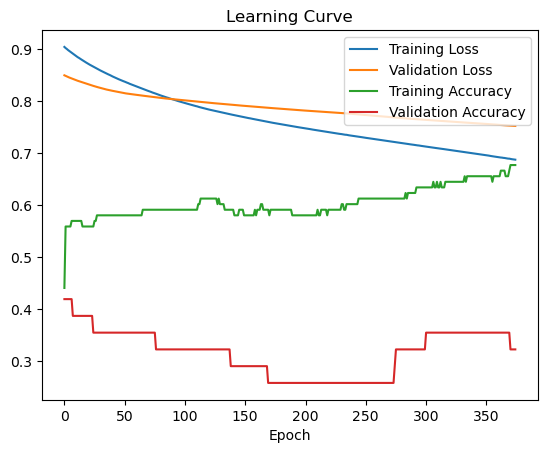

In [17]:
# Assigning new DataFrame to Data set variable
X = df_copy.values

# Number of trials with random combinations
num_trials = 15
for i in range(num_trials):
    
    # Random parameters
    params = {
        'units': np.random.choice(param_space['units']),
        'optimizer': np.random.choice(param_space['optimizer']),
        'learning_rate': np.random.choice(param_space['learning_rate']),
        'batch_size': np.random.choice(param_space['batch_size']),
        'epochs': np.random.choice(param_space['epochs']),
        'weight_decay': np.random.choice(param_space['weight_decay']),
        'momentum': np.random.choice(param_space['momentum']),
        'loss': np.random.choice(param_space['loss']),
        'activation': np.random.choice(param_space['activation']),
        'output_activation': np.random.choice(param_space['output_activation']),
        'metrics': np.random.choice(param_space['metrics']),
    }

    # Building the model
    model = Sequential()

    # Add fully connected units to the NN
    model.add(Dense(units=params['units'], activation=params['activation'], kernel_regularizer=regularizers.l2(params['weight_decay']), use_bias=True))
    model.add(Dense(units=1, activation=params['output_activation'], use_bias=True))
    
    # Set the optimizer with the sampled learning rate
    if params['optimizer'] == 'adam':
        optimizer = optimizers.Adam()
    elif params['optimizer'] == 'sgd':
        optimizer = optimizers.SGD()
    else:
        raise ValueError("Unsupported optimizer")

    # Sets the Loss Function, the Optimizer used in the model and the Metrics used for evaluation
    model.compile(loss=params['loss'], optimizer=optimizer, metrics=params['metrics'],)

    # Sets the Early Stopping for the model
    #early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Training of the model
    history = model.fit(
        x=X,
        y=y,
        epochs=params['epochs'],
        batch_size=params['batch_size'], 
        validation_split=0.25,
        verbose=0
    )


    # Evaluation of the model
    loss, accuracy = model.evaluate(X, y, verbose=0)

    # Reset of the previous Plot
    plt.figure()

    # Plot the learning curve
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.legend()

    # Print the used parameters
    print(f"Trial {i:>2}: Units={params['units']}, Learning Rate={params['learning_rate']}, Weight Decay={params['weight_decay']}, Epochs={params['epochs']}, Batch Size={params['batch_size']}, Momentum={params['momentum']} Accuracy={accuracy:.4f}")

    # Print of the Plot
    plt.show()